In [1]:
from nasbench import api
from hypernets.benchmark.nas_bench_101 import NasBench101
from hypernets.searchers.random_searcher import RandomSearcher
from hypernets.searchers.mcts_searcher import MCTSSearcher
from hypernets.searchers.evolution_searcher import EvolutionSearcher
from hypernets.core.meta_learner import MetaLearner
from hypernets.core.trial import get_default_trail_store, TrailHistory, DiskTrailStore, Trail
from tests import test_output_dir
import matplotlib.pyplot as plt
import random
import numpy as np

/Users/jack/opt/anaconda3/envs/hypernets/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#nasbench = api.NASBench('/Users/jack/workspace/NAS/nasbench_/nasbench_full.tfrecord')
#nasbench = api.NASBench('/Users/jack/workspace/NAS/nasbench/nasbench_only108.tfrecord')

hyn_nasbench = NasBench101(7, ops=['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3'],
                           nasbench_filepath='/Users/jack/workspace/NAS/nasbench/nasbench_only108.tfrecord')
num_repeat = 5

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 63 seconds


In [3]:
random_data = []
evolution_data = []
mcts_data = []
for repeat in range(num_repeat):
    print('Running repeat %d' % (repeat + 1))

    rs_searcher = RandomSearcher(hyn_nasbench.get_space, space_sample_validation_fn=hyn_nasbench.valid_space_sample)
    times, best_valid, best_test = hyn_nasbench.run_searcher(rs_searcher,max_trails=150000)
    random_data.append((times, best_valid, best_test))

    evol_searcher = EvolutionSearcher(hyn_nasbench.get_space,50,20,regularized=False, optimize_direction='max',space_sample_validation_fn=hyn_nasbench.valid_space_sample)
    times, best_valid, best_test = hyn_nasbench.run_searcher(evol_searcher,max_trails=150000, use_meta_learner=False)
    evolution_data.append((times, best_valid, best_test))

    mcts_searcher = MCTSSearcher(hyn_nasbench.get_space, optimize_direction='max',space_sample_validation_fn=hyn_nasbench.valid_space_sample)
    times, best_valid, best_test = hyn_nasbench.run_searcher(mcts_searcher,max_trails=150000, use_meta_learner=False)
    mcts_data.append((times, best_valid, best_test))


Running repeat 1
Initialize Meta Learner: dataset_id:nas_bench_101
Running repeat 2
Initialize Meta Learner: dataset_id:nas_bench_101
Running repeat 3
Initialize Meta Learner: dataset_id:nas_bench_101
Running repeat 4
Initialize Meta Learner: dataset_id:nas_bench_101
Running repeat 5
Initialize Meta Learner: dataset_id:nas_bench_101


In [ ]:
# random_data = []
# for repeat in range(10):
#     print('Running repeat %d' % (repeat + 1))

#     rs_searcher = RandomSearcher(hyn_nasbench.get_space, space_sample_validation_fn=valid_space_sample)
#     times, best_valid, best_test = run_searcher(rs_searcher,max_trails=1000000)
#     random_data.append((times, best_valid, best_test))

# #     evol_searcher = EvolutionSearcher(hyn_nasbench.get_space,50,20,regularized=False, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
# #     times, best_valid, best_test = run_searcher(evol_searcher,max_trails=150, use_meta_learner=False)
# #     evolution_data.append((times, best_valid, best_test))

# #     mcts_searcher = MCTSSearcher(hyn_nasbench.get_space, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
# #     times, best_valid, best_test = run_searcher(mcts_searcher,max_trails=150, use_meta_learner=False)
# #     mcts_data.append((times, best_valid, best_test))


Text(0.5, 1.0, 'MCTS search trajectories (red=validation, blue=test)')

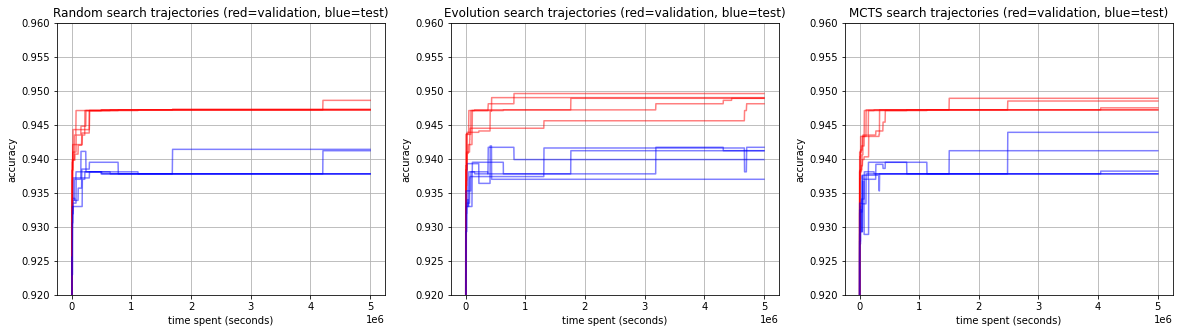

In [4]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1, 3, 3)
for times, best_valid, best_test in mcts_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('MCTS search trajectories (red=validation, blue=test)')


In [6]:
for i in range(num_repeat):
    print('mcts        |         evolution        |         random')
    #print(np.max(mcts_data[i][1]),np.max(evolution_data[i][1]),np.max(random_data[i][1]))
    print(np.max(mcts_data[i][2]),np.max(evolution_data[i][2]),np.max(random_data[i][2]))
    print(mcts_data[i][2].index(np.max(mcts_data[i][2])),
          evolution_data[i][2].index(np.max(evolution_data[i][2])),
          random_data[i][2].index(np.max(random_data[i][2])))
                                  
    print('-'*50)

mcts        |         evolution        |         random
0.9439102411270142 0.9419070482254028 0.94140625
1718 315 1359
--------------------------------------------------
mcts        |         evolution        |         random
0.9395031929016113 0.9412059187889099 0.9395031929016113
324 885 243
--------------------------------------------------
mcts        |         evolution        |         random
0.9412059187889099 0.9417067170143127 0.9412059187889099
1316 2798 3382
--------------------------------------------------
mcts        |         evolution        |         random
0.9378004670143127 0.9417067170143127 0.9411057829856873
236 186 122
--------------------------------------------------
mcts        |         evolution        |         random
0.9382011294364929 0.9417067170143127 0.9381009340286255
3255 1601 192
--------------------------------------------------


Text(0.5, 1.0, 'MCTS search trajectories (red=validation, blue=test)')

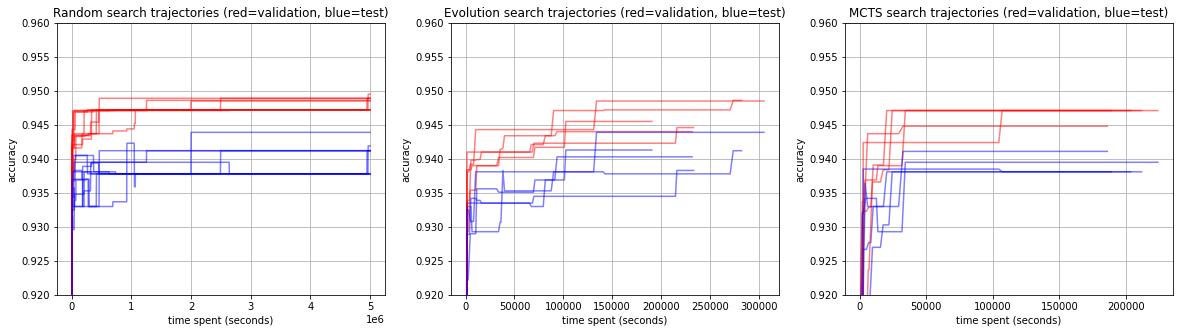

In [16]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1, 3, 3)
for times, best_valid, best_test in mcts_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('MCTS search trajectories (red=validation, blue=test)')


In [17]:
for i in range(5):
    print('mcts        |         evolution        |         random')
    #print(np.max(mcts_data[i][1]),np.max(evolution_data[i][1]),np.max(random_data[i][1]))
    print(np.max(mcts_data[i][2]),np.max(evolution_data[i][2]),np.max(random_data[i][2]))
    print(mcts_data[i][2].index(np.max(mcts_data[i][2])),
          evolution_data[i][2].index(np.max(evolution_data[i][2])),
          random_data[i][2].index(np.max(random_data[i][2])))
                                  
    print('-'*50)

mcts        |         evolution        |         random
0.9381009340286255 0.9412059187889099 0.9412059187889099
16 147 4034
--------------------------------------------------
mcts        |         evolution        |         random
0.9381009340286255 0.9413061141967773 0.940504789352417
16 86 13
--------------------------------------------------
mcts        |         evolution        |         random
0.9385015964508057 0.9383012652397156 0.9419070482254028
1 137 4004
--------------------------------------------------
mcts        |         evolution        |         random
0.9395031929016113 0.9403044581413269 0.9412059187889099
24 70 996
--------------------------------------------------
mcts        |         evolution        |         random
0.9411057829856873 0.9439102411270142 0.942307710647583
26 88 767
--------------------------------------------------


In [ ]:
random_data = []
evolution_data = []
mcts_data = []
for repeat in range(5):
    print('Running repeat %d' % (repeat + 1))

    rs_searcher = RandomSearcher(hyn_nasbench.get_space, space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(rs_searcher,max_trails=150)
    random_data.append((times, best_valid, best_test))

    evol_searcher = EvolutionSearcher(hyn_nasbench.get_space,50,20,regularized=False, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(evol_searcher,max_trails=150, use_meta_learner=True)
    evolution_data.append((times, best_valid, best_test))

    mcts_searcher = MCTSSearcher(hyn_nasbench.get_space, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(mcts_searcher,max_trails=150, use_meta_learner=True)
    mcts_data.append((times, best_valid, best_test))


Text(0.5, 1.0, 'MCTS search trajectories (red=validation, blue=test)')

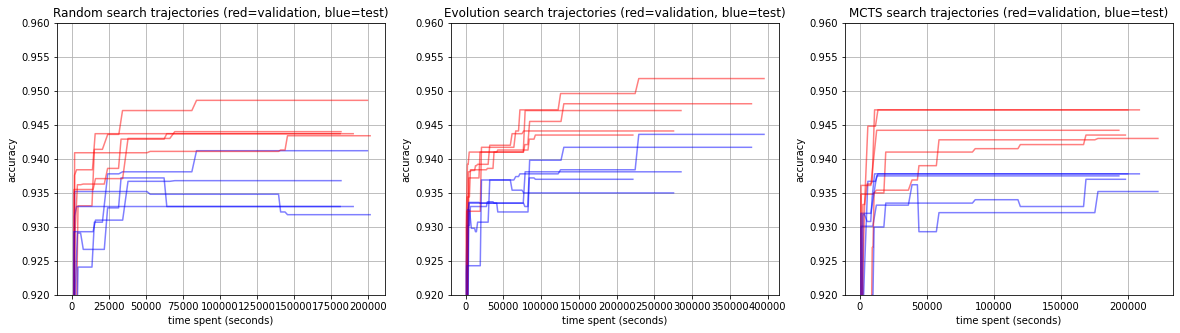

In [7]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1, 3, 3)
for times, best_valid, best_test in mcts_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('MCTS search trajectories (red=validation, blue=test)')


In [8]:
for i in range(5):
    print('mcts        |         evolution        |         random')
    #print(np.max(mcts_data[i][1]),np.max(evolution_data[i][1]),np.max(random_data[i][1]))
    print(np.max(mcts_data[i][2]),np.max(evolution_data[i][2]),np.max(random_data[i][2]))
    print(mcts_data[i][2].index(np.max(mcts_data[i][2])),
          evolution_data[i][2].index(np.max(evolution_data[i][2])),
          random_data[i][2].index(np.max(random_data[i][2])))
                                  
    print('-'*50)

mcts        |         evolution        |         random
0.9361979365348816 0.9417067170143127 0.9412059187889099
25 80 63
--------------------------------------------------
mcts        |         evolution        |         random
0.9369992017745972 0.9368990659713745 0.9351963400840759
131 28 2
--------------------------------------------------
mcts        |         evolution        |         random
0.9378004670143127 0.9371995329856873 0.9329928159713745
11 71 3
--------------------------------------------------
mcts        |         evolution        |         random
0.9375 0.9436097741127014 0.9371995329856873
8 110 28
--------------------------------------------------
mcts        |         evolution        |         random
0.9378004670143127 0.9381009340286255 0.9367988705635071
9 63 51
--------------------------------------------------
